## Work Notebook for Requirements Engineering Journal Article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.stats.api as sms

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]

In [8]:
all_topics = []
reg_topics = []
simple_reg_topics = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    simple_reg_topics.append('topic_{}'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*90
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']
all_data['log_duration'] = np.log(all_data['duration_median'] + 1e-7)
all_data['log_duration_mean'] = np.log(all_data['duration_mean'] + 1e-7)
all_data['pct_under_30'] = all_data['under_30'] / all_data['total_issues']
all_data['pct_under_60'] = all_data['under_60'] / all_data['total_issues']
all_data['pct_under_90'] = all_data['under_90'] / all_data['total_issues']
all_data['issues_per_user'] = all_data['total_issues'] / all_data['num_users']
all_data.to_csv('/home/matt/research_data_25.csv', index=False)

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

In [13]:
def glm_marginal_effect(variable, res, X, all_data):
    """Computes the GLM marginal effects for the variable.
    
    Parameters
    ----------
    variable : str
        the variable for which we would like to calculate the marginal effect
    res : sm.model
        results of the linear regression
    X : pd.DataFrame
        the input to the linear regression
    all_data : pd.DataFrame
        the full set of input data
        
    Returns
    -------
    marginal_effect : float
    """
    data = all_data.copy(deep=True)
    param = res.params[variable]
    cross_term = '{}Xcrowd_pct'.format(variable)
    if cross_term in res.params:
        data['effect'] = param + data['crowd_pct'] * res.params[cross_term]
    else:
        data['effect'] = param
    data['prediction'] = res.predict(X)
    data['marginal_effect'] = data['effect'] * data['prediction']
    return data['marginal_effect'].mean()

In [14]:
def compute_pca(X, n_components=50):
    """Compute principal component analysis only on the topic columns
    
    Parameters
    ----------
    X : pd.DataFrame
        the dataframe that contains the columns for the regression model
    n_compnents : int
        the number of principal components to retain
        
    Returns
    -------
    final_df : pd.DataFrame
        the data frame for the linear regression, with the topic columns
        replaced by their principal components
    """
    topic_columns = [x for x in X.columns if 'topic' in x]
    topic_matrix = X[topic_columns]
    pca = PCA(n_components=n_components)
    pca_matrix = pca.fit_transform(topic_matrix)
    pca_df = pd.DataFrame(data = pca_matrix, columns = ['pc_{}'.format(i) for i in range(pca_matrix.shape[1])])
    pca_df['index'] = range(len(pca_df))
    X['index'] = range(len(X))
    final_df = X.merge(pca_df)
    del final_df['index']
    for col in final_df:
        if 'topic' in col:
            del final_df[col]
    return final_df

### Exploratory Data Analysis

(0, 1)

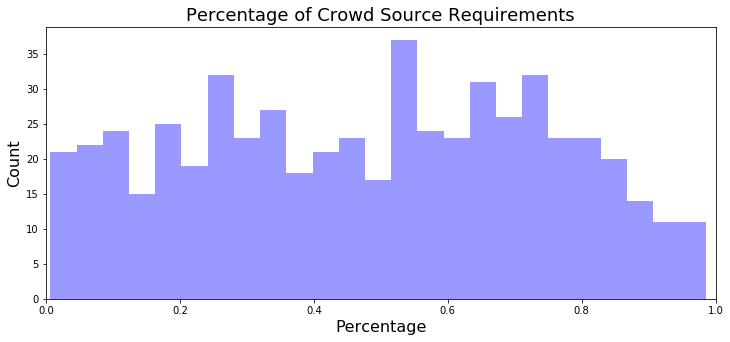

In [16]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['crowd_pct'], kde=False, color='blue', bins=25)
plt.title('Percentage of Crowd Source Requirements', fontsize=18)
plt.xlabel('Percentage', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 1])

(1, 10)

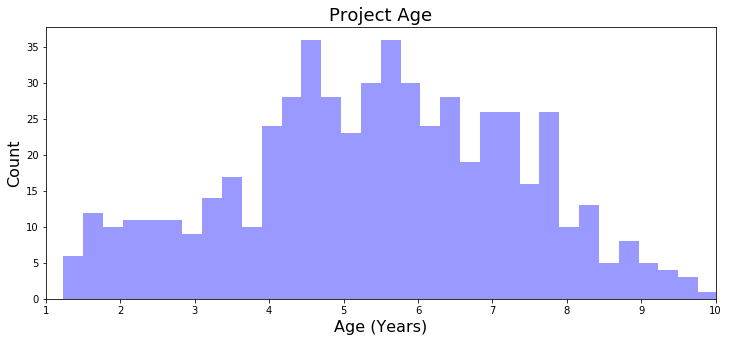

In [23]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['project_age']/365, kde=False, color='blue', bins=54)
plt.title('Project Age', fontsize=18)
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 10])

(1, 40)

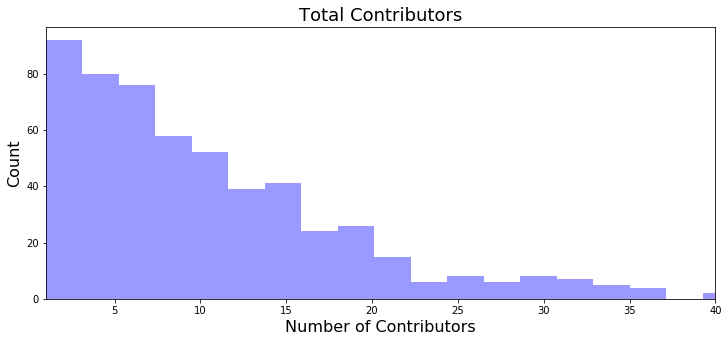

In [42]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['total_contributors'], kde=False, color='blue', bins=40)
plt.title('Total Contributors', fontsize=18)
plt.xlabel('Number of Contributors', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 40])

(1, 150)

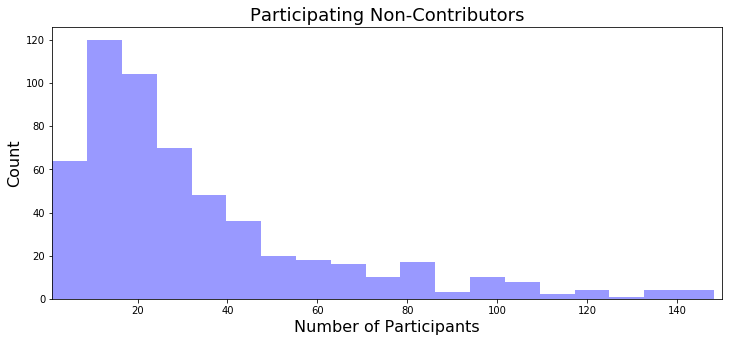

In [41]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['num_users'], kde=False, color='blue', bins=40)
plt.title('Participating Non-Contributors', fontsize=18)
plt.xlabel('Number of Participants', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([1, 150])

(30, 600)

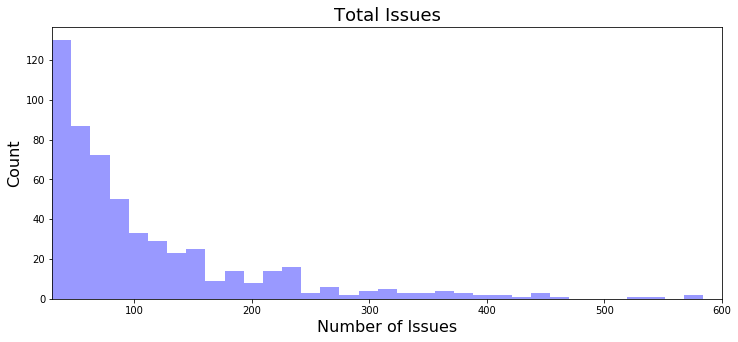

In [43]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['total_issues'], kde=False, color='blue', bins=100)
plt.title('Total Issues', fontsize=18)
plt.xlabel('Number of Issues', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([30, 600])

In [44]:
all_data[['crowd_pct', 'project_age', 'total_contributors', 'num_users', 'total_issues']].describe()

,crowd_pct,project_age,total_contributors,num_users,total_issues
count,562.000000,562.000000,562.000000,562.000000,562.000000
mean,0.480865,1992.505338,11.539146,34.213523,119.026690
std,0.263940,708.714573,10.587185,32.851103,128.293396
min,0.006711,451.000000,1.000000,1.000000,30.000000
25%,0.265306,1549.000000,5.000000,14.000000,48.250000
50%,0.500000,2011.500000,9.000000,24.000000,77.000000
75%,0.699603,2509.000000,15.000000,42.000000,141.750000
max,0.985294,5705.000000,86.000000,311.000000,1660.000000


In [45]:
(all_data['project_age'] / 365).describe()

count    562.000000
mean       5.458919
std        1.941684
min        1.235616
25%        4.243836
50%        5.510959
75%        6.873973
max       15.630137
Name: project_age, dtype: float64

### Regression on Average Comments

Text(0, 0.5, 'Count')

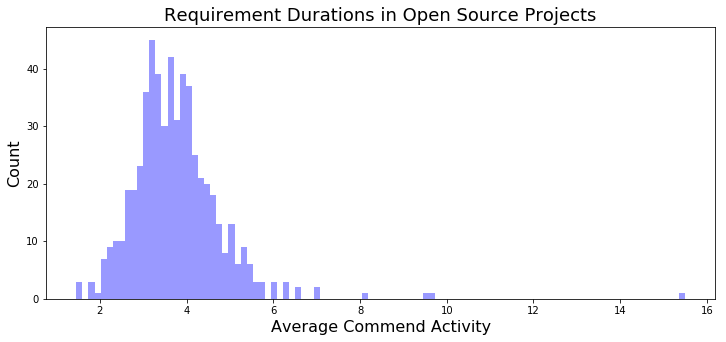

In [18]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Average Commend Activity', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [19]:
all_data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [20]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           2.32e-34
Time:                        22:55:50   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [49]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age +
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    topic_0:topic_1 + topic_0:topic_7 + topic_0:topic_9 + topic_0:topic_10 + 
    topic_0:topic_18 + topic_0:topic_19 + topic_0:topic_21 + 
    topic_1:topic_2 + topic_1:topic_9 + topic_1:topic_10 + topic_1:topic_13 + 
    topic_1:topic_14 + topic_1:topic_21 + topic_2:topic_11 + 
    topic_2:topic_12 + topic_2:topic_18 + topic_2:topic_20 + 
    topic_2:topic_22 + topic_3:topic_5 + topic_3:topic_11 + topic_3:topic_21 + 
    topic_4:topic_8 + topic_4:topic_18 + topic_5:topic_7 + topic_5:topic_9 + 
    topic_5:topic_11 + topic_5:topic_15 + topic_5:topic_17 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_8 + topic_6:topic_12 + 
    topic_6:topic_14 + topic_6:topic_16 + topic_6:topic_17 + 
    topic_6:topic_18 + topic_6:topic_19 + topic_7:topic_8 + topic_7:topic_16 + 
    topic_7:topic_23 + topic_8:topic_9 + topic_8:topic_15 + topic_9:topic_10 + 
    topic_9:topic_16 + topic_9:topic_19 + topic_9:topic_20 + 
    topic_9:topic_22 + topic_10:topic_12 + topic_10:topic_16 + 
    topic_10:topic_20 + topic_10:topic_22 + topic_10:topic_23 + 
    topic_11:topic_13 + topic_11:topic_14 + topic_11:topic_15 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_22 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_22 + 
    topic_15:topic_16 + topic_15:topic_18 + topic_15:topic_21 + 
    topic_16:topic_19 + topic_16:topic_22 + topic_17:topic_18 + 
    topic_17:topic_20 + topic_17:topic_22 + topic_18:topic_23 + 
    topic_19:topic_20 + topic_19:topic_21 + topic_19:topic_23 + 
    topic_20:topic_21 + topic_21:topic_22 + topic_3:topic_8 + 
    topic_7:topic_18 + topic_5:topic_12

"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 75)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     4.372
Date:                Sun, 12 Jan 2020   Prob (F-statistic):           3.83e-25
Time:                        14:48:15   Log-Likelihood:                -679.32
No. Observations:                 562   AIC:                             1529.
Df Residuals:                     477   BIC:                             1897.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

(-2.0, 2.0)

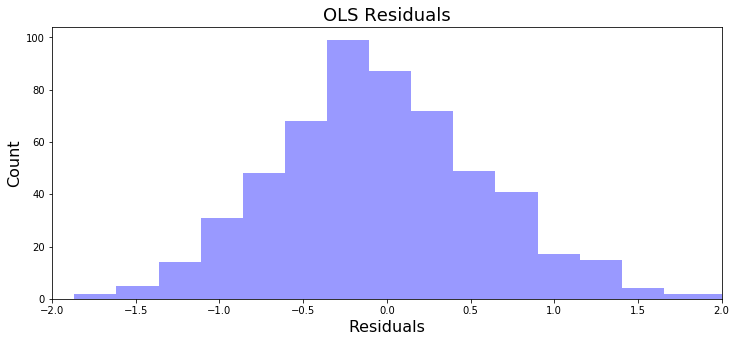

In [22]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

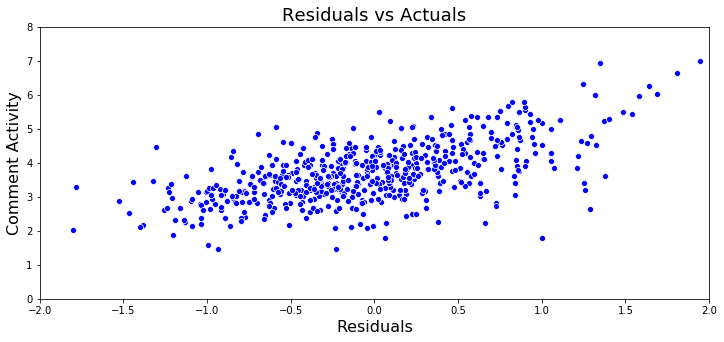

In [23]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [50]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-12 14:48:21,811 [9128] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5172436840275236
85
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      477
Model Family:                   Gamma   Df Model:                           84
Link Function:                    log   Scale:                        0.042621
Method:                          IRLS   Log-Likelihood:                -573.05
Date:                Sun, 12 Jan 2020   Deviance:                       18.329
Time:                        14:48:22   Pearson chi2:                     20.3
No. Iterations:                    16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [25]:
glm_marginal_effect('avg_clustering', res, X, all_data)

2.3890554438358644

In [26]:
glm_marginal_effect('avg_min_path', res, X, all_data)

-1.8519801249191774

In [27]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

4.862372783657044

In [28]:
all_data['comment_prediction'] = res.predict(X)

(0, 1.5)

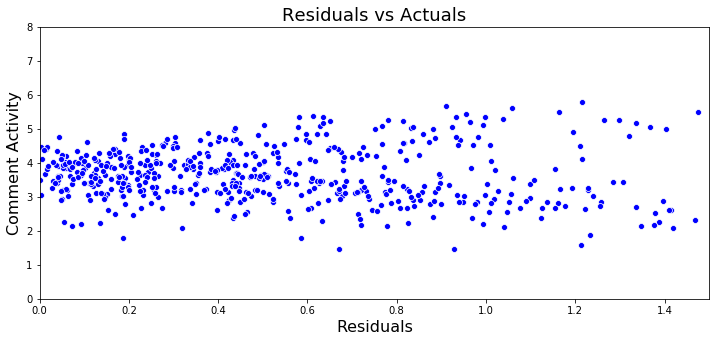

In [29]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['avg_comments']), y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([0, 1.5])

In [30]:
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                              + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

0.1821000095134634


2020-01-11 22:55:56,853 [8657] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

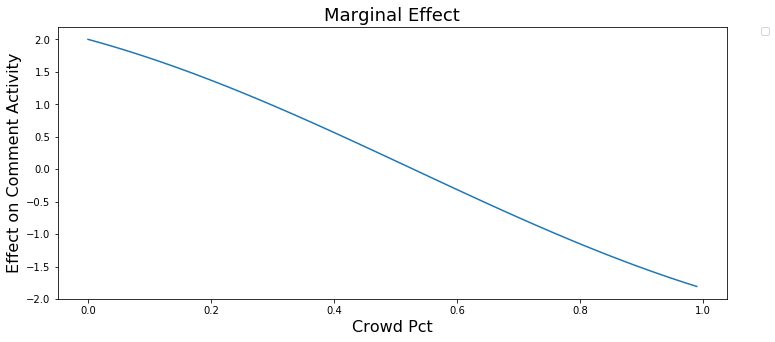

In [31]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct'] = crowd_pct
    effects_data['crowd_pct_2'] = crowd_pct**2


    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

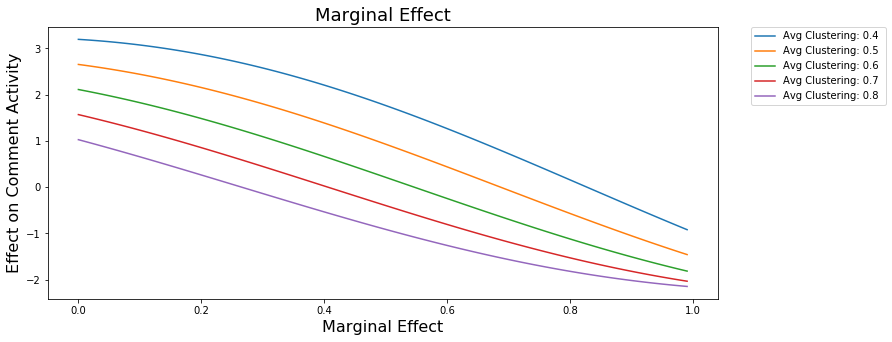

In [32]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

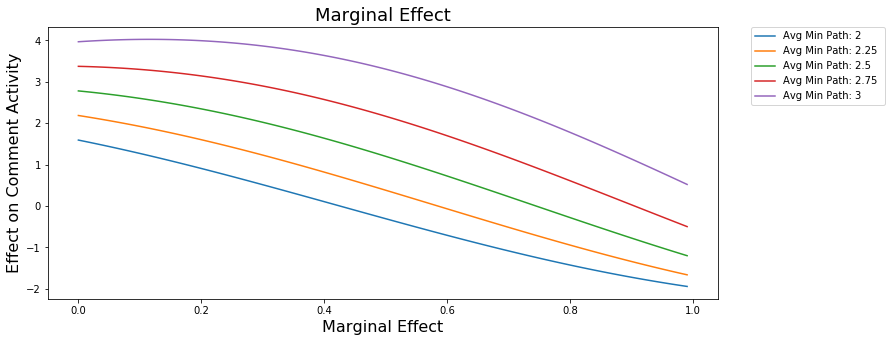

In [33]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

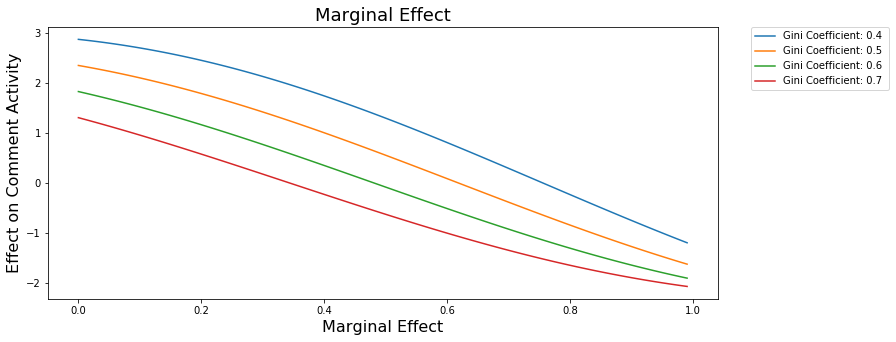

In [34]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Regression on Issues Submitted Over Time

Text(0, 0.5, 'Count')

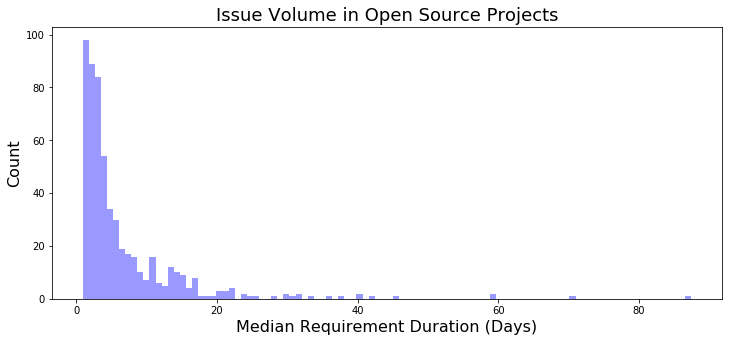

In [35]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Issue Volume in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [36]:
all_data['issues_over_time'].describe()

count    562.000000
mean       6.623063
std        8.525084
min        0.906344
25%        2.172254
50%        3.643554
75%        7.604083
max       87.415541
Name: issues_over_time, dtype: float64

In [37]:
y, X = dmatrices('issues_over_time ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     47.25
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           9.23e-68
Time:                        22:56:30   Log-Likelihood:                -1827.3
No. Observations:                 562   AIC:                             3677.
Df Residuals:                     551   BIC:                             3724.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [38]:
formula = """
issues_over_time ~ crowd_pct_2 + avg_clustering + 
    gini_coefficient + avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + 
    gini_coefficientXcrowd_pct + total_contributors + project_age + 
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    avg_min_path + topic_0:topic_1 + topic_0:topic_2 + topic_0:topic_3 + 
    topic_0:topic_5 + topic_0:topic_6 + topic_0:topic_7 + topic_0:topic_9 + 
    topic_0:topic_10 + topic_0:topic_11 + topic_0:topic_13 + 
    topic_0:topic_14 + topic_0:topic_15 + topic_0:topic_16 + 
    topic_0:topic_17 + topic_0:topic_18 + topic_0:topic_20 + 
    topic_0:topic_22 + topic_0:topic_23 + topic_1:topic_2 + topic_1:topic_4 + 
    topic_1:topic_5 + topic_1:topic_6 + topic_1:topic_10 + topic_1:topic_12 + 
    topic_1:topic_13 + topic_1:topic_14 + topic_1:topic_16 + 
    topic_1:topic_17 + topic_1:topic_18 + topic_1:topic_20 + 
    topic_2:topic_5 + topic_2:topic_16 + topic_2:topic_17 + topic_2:topic_19 + 
    topic_2:topic_22 + topic_2:topic_23 + topic_3:topic_7 + topic_3:topic_8 + 
    topic_3:topic_9 + topic_3:topic_11 + topic_3:topic_17 + topic_3:topic_18 + 
    topic_3:topic_22 + topic_4:topic_7 + topic_4:topic_10 + topic_4:topic_11 + 
    topic_4:topic_12 + topic_4:topic_14 + topic_4:topic_15 + 
    topic_4:topic_16 + topic_4:topic_18 + topic_4:topic_22 + 
    topic_4:topic_23 + topic_5:topic_6 + topic_5:topic_8 + topic_5:topic_11 + 
    topic_5:topic_14 + topic_5:topic_16 + topic_5:topic_17 + 
    topic_5:topic_18 + topic_6:topic_8 + topic_6:topic_10 + topic_6:topic_11 + 
    topic_6:topic_12 + topic_6:topic_14 + topic_6:topic_16 + 
    topic_6:topic_17 + topic_6:topic_18 + topic_6:topic_21 + 
    topic_6:topic_22 + topic_7:topic_9 + topic_7:topic_10 + topic_7:topic_11 + 
    topic_7:topic_17 + topic_7:topic_19 + topic_7:topic_20 + 
    topic_7:topic_22 + topic_8:topic_9 + topic_8:topic_10 + topic_8:topic_14 + 
    topic_8:topic_15 + topic_8:topic_17 + topic_8:topic_19 + 
    topic_8:topic_21 + topic_8:topic_22 + topic_9:topic_13 + 
    topic_9:topic_16 + topic_9:topic_18 + topic_9:topic_19 + 
    topic_9:topic_21 + topic_9:topic_22 + topic_9:topic_23 + 
    topic_10:topic_12 + topic_10:topic_15 + topic_10:topic_17 + 
    topic_10:topic_18 + topic_10:topic_19 + topic_10:topic_21 + 
    topic_10:topic_22 + topic_11:topic_13 + topic_11:topic_14 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_21 + 
    topic_11:topic_23 + topic_12:topic_13 + topic_12:topic_15 + 
    topic_12:topic_19 + topic_12:topic_22 + topic_12:topic_23 + 
    topic_13:topic_16 + topic_13:topic_17 + topic_13:topic_18 + 
    topic_13:topic_19 + topic_13:topic_20 + topic_14:topic_16 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_23 + 
    topic_15:topic_16 + topic_15:topic_17 + topic_15:topic_18 + 
    topic_15:topic_20 + topic_15:topic_21 + topic_16:topic_17 + 
    topic_16:topic_22 + topic_16:topic_23 + topic_17:topic_19 + 
    topic_17:topic_20 + topic_17:topic_21 + topic_17:topic_23 + 
    topic_18:topic_19 + topic_18:topic_20 + topic_18:topic_22 + 
    topic_18:topic_23 + topic_19:topic_23 + topic_20:topic_21 + 
    topic_20:topic_23 + topic_21:topic_22 + topic_22:topic_23
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 50)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     10.25
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           1.84e-55
Time:                        22:56:31   Log-Likelihood:                -1779.2
No. Observations:                 562   AIC:                             3678.
Df Residuals:                     502   BIC:                             3938.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Text(0, 0.5, 'Count')

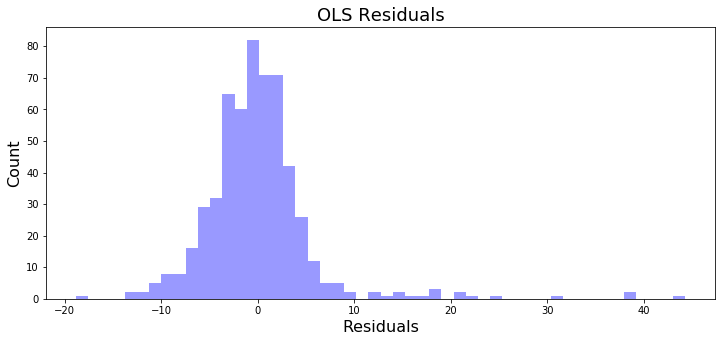

In [39]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Issues over Time')

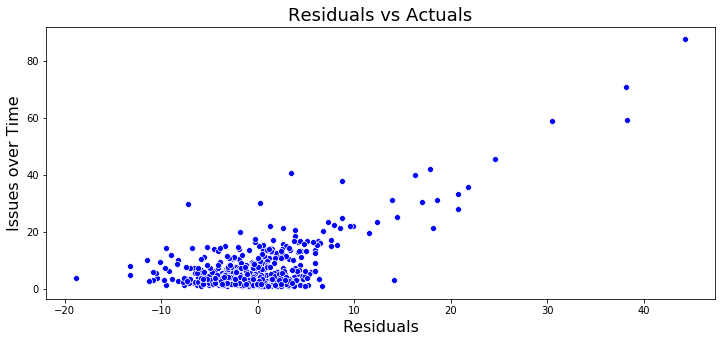

In [40]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
#plt.ylim([0, 2.5])
#plt.xlim([-0.75, .75])

In [41]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-11 22:56:32,759 [8657] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.6981929587874266
60
                 Generalized Linear Model Regression Results                  
Dep. Variable:       issues_over_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      502
Model Family:                   Gamma   Df Model:                           59
Link Function:                    log   Scale:                         0.36827
Method:                          IRLS   Log-Likelihood:                -1270.0
Date:                Sat, 11 Jan 2020   Deviance:                       151.87
Time:                        22:56:33   Pearson chi2:                     185.
No. Iterations:                    66                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [42]:
glm_marginal_effect('avg_clustering', res, X, all_data)

-2.3428395399879944

In [43]:
glm_marginal_effect('avg_min_path', res, X, all_data)

-0.2588607532717878

In [44]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

16.660385517679522

In [45]:
avg_clustering = all_data['avg_clustering']
avg_min_path = all_data['avg_min_path']
crowd_pct = all_data['crowd_pct']


effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct_2'] = crowd_pct**2

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                              + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-9.568312618960727


2020-01-11 22:56:36,416 [8657] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

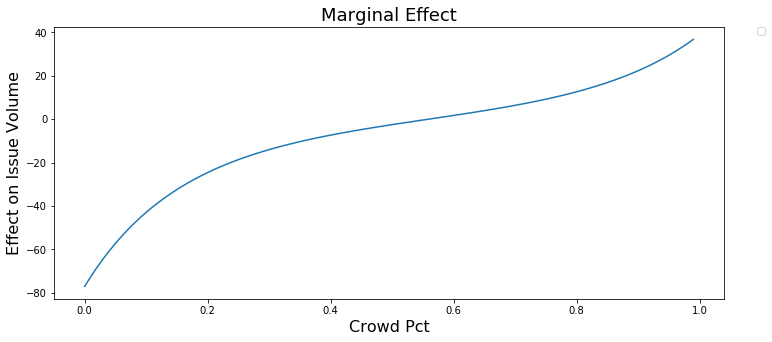

In [46]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct_2'] = crowd_pct**2

    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

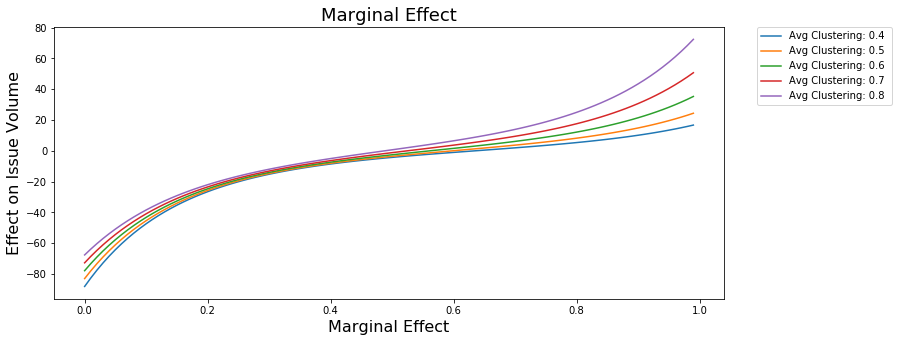

In [47]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

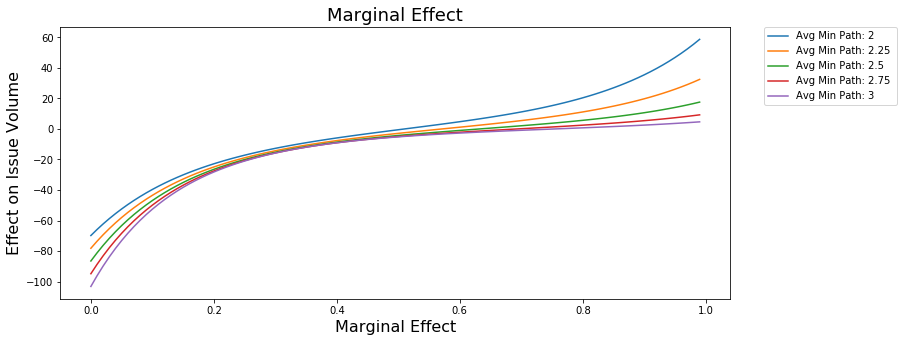

In [48]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

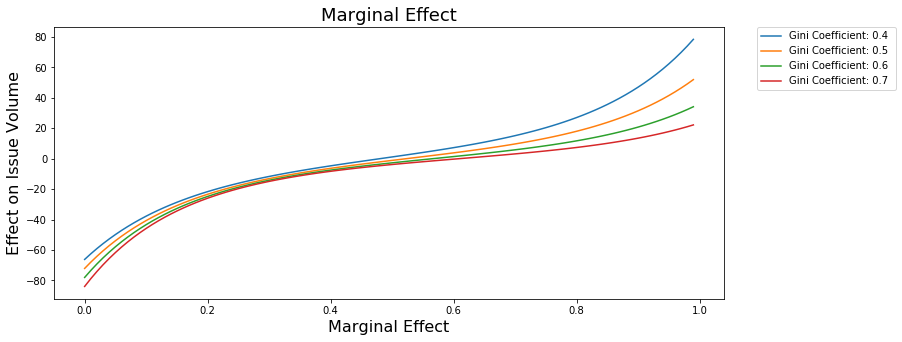

In [49]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Pct Closed out under 30

(0, 1)

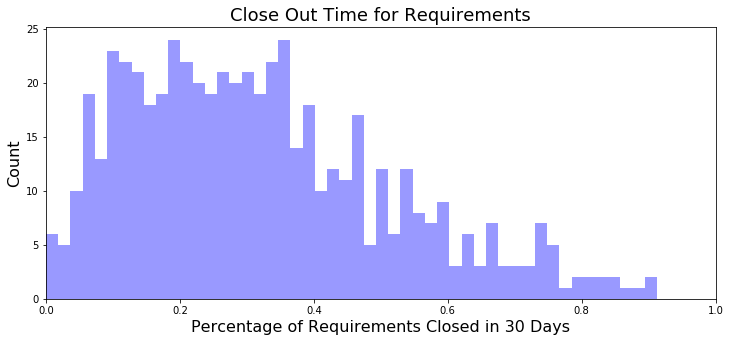

In [50]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['pct_under_30'], kde=False, color='blue', bins=50)
plt.title('Close Out Time for Requirements', fontsize=18)
plt.xlabel('Percentage of Requirements Closed in 30 Days', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,1])

In [51]:
all_data['pct_under_30'].describe()

count    562.000000
mean       0.319167
std        0.195067
min        0.000000
25%        0.166806
50%        0.288506
75%        0.435968
max        0.912752
Name: pct_under_30, dtype: float64

In [52]:
y, X = dmatrices('pct_under_30 ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           pct_under_30   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     15.14
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           5.01e-24
Time:                        22:57:03   Log-Likelihood:                 189.83
No. Observations:                 562   AIC:                            -357.7
Df Residuals:                     551   BIC:                            -310.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [52]:
formula = """
 pct_under_30 ~ crowd_pct_2 + avg_clustering + gini_coefficient + 
    avg_min_pathXcrowd_pct + project_age + topic_0 + topic_1 + 
    topic_2 + topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + 
    topic_8 + topic_9 + topic_10 + topic_11 + topic_12 + topic_13 + 
    topic_14 + topic_15 + topic_16 + topic_17 + topic_18 + topic_19 + 
    topic_20 + topic_21 + topic_22 + topic_23 + topic_0:topic_6 + 
    topic_0:topic_7 + topic_0:topic_8 + topic_0:topic_18 + topic_0:topic_20 + 
    topic_0:topic_22 + topic_0:topic_23 + topic_1:topic_10 + 
    topic_1:topic_11 + topic_1:topic_13 + topic_1:topic_14 + 
    topic_1:topic_17 + topic_1:topic_20 + topic_1:topic_22 + 
    topic_2:topic_4 + topic_2:topic_10 + topic_2:topic_16 + topic_2:topic_17 + 
    topic_2:topic_18 + topic_2:topic_22 + topic_3:topic_4 + topic_3:topic_9 + 
    topic_3:topic_10 + topic_3:topic_13 + topic_3:topic_15 + 
    topic_3:topic_16 + topic_3:topic_21 + topic_3:topic_22 + 
    topic_4:topic_6 + topic_4:topic_9 + topic_4:topic_10 + topic_4:topic_12 + 
    topic_4:topic_14 + topic_4:topic_19 + topic_4:topic_23 + 
    topic_5:topic_6 + topic_5:topic_9 + topic_5:topic_15 + topic_5:topic_18 + 
    topic_5:topic_19 + topic_5:topic_23 + topic_6:topic_10 + 
    topic_6:topic_17 + topic_6:topic_22 + topic_7:topic_8 + topic_7:topic_9 + 
    topic_7:topic_10 + topic_7:topic_12 + topic_7:topic_14 + 
    topic_7:topic_15 + topic_7:topic_16 + topic_7:topic_20 + 
    topic_8:topic_9 + topic_8:topic_12 + topic_8:topic_14 + topic_8:topic_17 + 
    topic_8:topic_18 + topic_9:topic_13 + topic_9:topic_15 + 
    topic_9:topic_17 + topic_9:topic_19 + topic_9:topic_22 + 
    topic_9:topic_23 + topic_10:topic_15 + topic_10:topic_16 + 
    topic_10:topic_18 + topic_10:topic_19 + topic_10:topic_21 + 
    topic_11:topic_15 + topic_11:topic_17 + topic_12:topic_18 + 
    topic_12:topic_19 + topic_12:topic_20 + topic_13:topic_14 + 
    topic_13:topic_16 + topic_13:topic_19 + topic_13:topic_22 + 
    topic_13:topic_23 + topic_14:topic_18 + topic_14:topic_19 + 
    topic_14:topic_22 + topic_15:topic_20 + topic_15:topic_21 + 
    topic_15:topic_23 + topic_16:topic_18 + topic_16:topic_23 + 
    topic_17:topic_19 + topic_17:topic_23 + topic_18:topic_21 + 
    topic_18:topic_22 + topic_18:topic_23 + topic_19:topic_20 + 
    topic_20:topic_22 + topic_21:topic_23 + topic_2:topic_19 + 
    topic_0:topic_10 + topic_1:topic_3
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 50)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           pct_under_30   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     3.573
Date:                Sun, 12 Jan 2020   Prob (F-statistic):           2.44e-14
Time:                        14:51:22   Log-Likelihood:                 213.80
No. Observations:                 562   AIC:                            -315.6
Df Residuals:                     506   BIC:                            -73.03
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [54]:
final_df = X.copy()
final_df['pct_under_30'] = y['pct_under_30']
del final_df['Intercept']
final_df.to_csv('~/pct_under_30_data.csv', index=False)

Text(0, 0.5, 'Count')

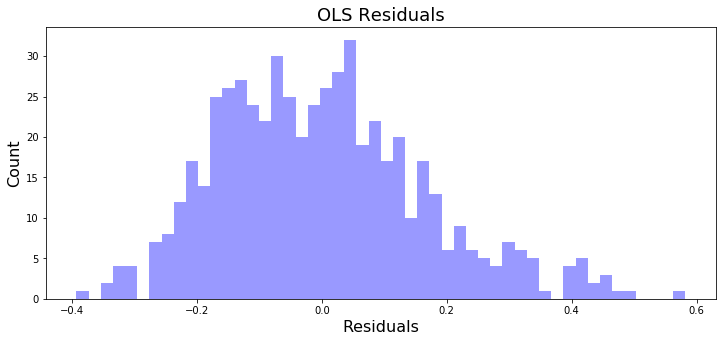

In [55]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

(-0.2, 0.2)

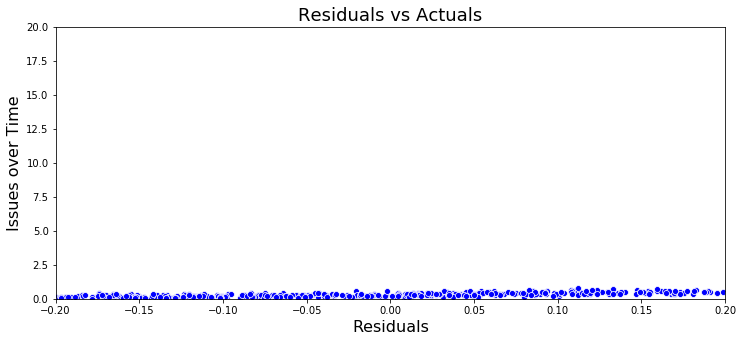

In [56]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['pct_under_30'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 20])
plt.xlim([-0.2, 0.2])

In [57]:
params = {'crowd_pct_2': 1.45256931291647,
          'avg_min_pathXcrowd_pct': -1.0979488383932,
          'avg_clustering': -1.94602300853525,
          'gini_coefficient': 1.99828032440915}

In [58]:
for x in params:
    print('{}: {}'.format(x, np.exp(params[x])))

crowd_pct_2: 4.274081873611587
gini_coefficient: 7.3763602390268606
avg_min_pathXcrowd_pct: 0.33355455680224094
avg_clustering: 0.14284102098406498


In [59]:
np.exp(np.mean(all_data['crowd_pct']*params['avg_min_pathXcrowd_pct']))

0.5898038581443397

In [60]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)

effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['crowd_pct_2'] = crowd_pct**2
        
effects_data['crowd_pct_param'] = avg_min_path * res.params['avg_min_pathXcrowd_pct']
effects_data['total_effect'] = np.exp(2 * params['crowd_pct_2'] * crowd_pct
                                      + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

3.649053275650091


<Figure size 864x360 with 0 Axes>

2020-01-11 22:57:06,837 [8657] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Marginal Effect')

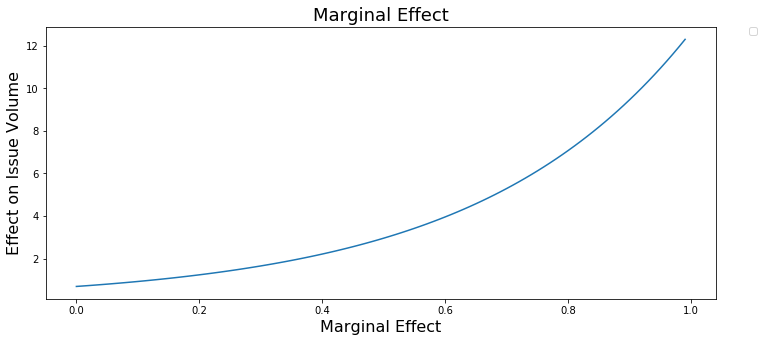

In [61]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']

for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['crowd_pct_2'] = crowd_pct**2
        
    effects_data['crowd_pct_param'] = avg_min_path * res.params['avg_min_pathXcrowd_pct']
    effects_data['total_effect'] = np.exp(2 * params['crowd_pct_2'] * crowd_pct
                                            + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

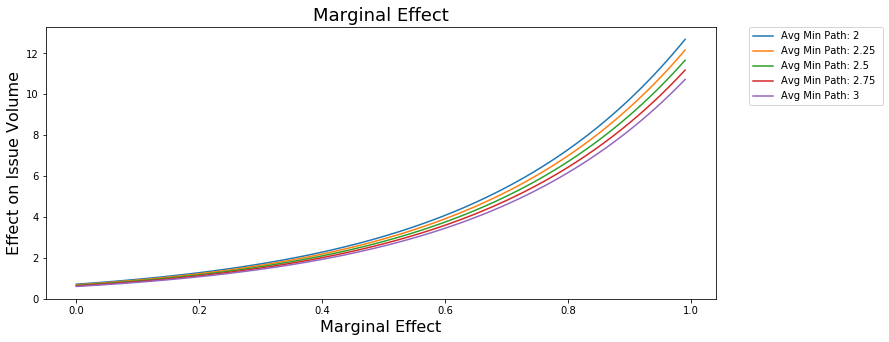

In [62]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['crowd_pct_2'] = crowd_pct**2
        
        effects_data['crowd_pct_param'] = avg_min_path * res.params['avg_min_pathXcrowd_pct']
        effects_data['total_effect'] = np.exp(2 * params['crowd_pct_2'] * crowd_pct
                                              + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Avg First Comment Time

In [63]:
all_data['avg_first_comment'].describe()

count    562.000000
mean      29.004449
std       37.018716
min        0.169014
25%        8.695482
50%       18.767917
75%       35.140768
max      389.746114
Name: avg_first_comment, dtype: float64

(0, 150)

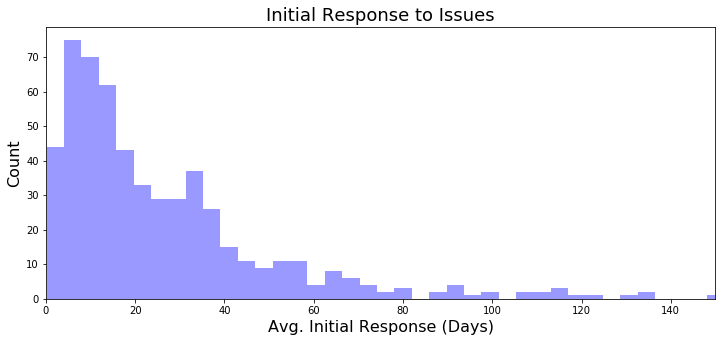

In [64]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_first_comment'], kde=False, color='blue', bins=100)
plt.title('Initial Response to Issues', fontsize=18)
plt.xlabel('Avg. Initial Response (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 150])

In [65]:
y, X = dmatrices('avg_first_comment ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_first_comment   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     24.79
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           8.39e-39
Time:                        22:57:12   Log-Likelihood:                -2722.2
No. Observations:                 562   AIC:                             5466.
Df Residuals:                     551   BIC:                             5514.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [66]:
formula = """
avg_first_comment ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    total_contributors + project_age + topic_0 + topic_1 + topic_2 + 
    topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + topic_8 + 
    topic_9 + topic_10 + topic_11 + topic_12 + topic_13 + topic_14 + 
    topic_15 + topic_16 + topic_17 + topic_18 + topic_19 + topic_20 + 
    topic_21 + topic_22 + topic_23 + topic_0:topic_5 + topic_0:topic_11 + 
    topic_0:topic_12 + topic_0:topic_13 + topic_0:topic_15 + 
    topic_0:topic_21 + topic_1:topic_3 + topic_1:topic_4 + topic_1:topic_7 + 
    topic_1:topic_8 + topic_1:topic_11 + topic_1:topic_12 + topic_1:topic_17 + 
    topic_1:topic_19 + topic_1:topic_21 + topic_1:topic_22 + 
    topic_2:topic_6 + topic_2:topic_7 + topic_2:topic_12 + topic_2:topic_13 + 
    topic_2:topic_14 + topic_2:topic_15 + topic_2:topic_18 + 
    topic_2:topic_20 + topic_2:topic_22 + topic_3:topic_6 + topic_3:topic_11 + 
    topic_3:topic_13 + topic_3:topic_14 + topic_3:topic_15 + 
    topic_3:topic_16 + topic_3:topic_19 + topic_3:topic_21 + 
    topic_3:topic_22 + topic_4:topic_5 + topic_4:topic_7 + topic_4:topic_8 + 
    topic_4:topic_9 + topic_4:topic_12 + topic_4:topic_14 + topic_4:topic_18 + 
    topic_4:topic_22 + topic_5:topic_11 + topic_5:topic_12 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_9 + topic_6:topic_13 + 
    topic_6:topic_17 + topic_6:topic_18 + topic_6:topic_19 + 
    topic_6:topic_21 + topic_6:topic_22 + topic_7:topic_9 + topic_7:topic_12 + 
    topic_7:topic_22 + topic_8:topic_11 + topic_8:topic_12 + 
    topic_8:topic_13 + topic_8:topic_14 + topic_8:topic_15 + 
    topic_8:topic_18 + topic_8:topic_21 + topic_9:topic_12 + 
    topic_9:topic_14 + topic_9:topic_18 + topic_9:topic_20 + 
    topic_9:topic_21 + topic_9:topic_22 + topic_10:topic_12 + 
    topic_10:topic_20 + topic_10:topic_21 + topic_11:topic_14 + 
    topic_11:topic_15 + topic_11:topic_17 + topic_11:topic_19 + 
    topic_11:topic_20 + topic_11:topic_22 + topic_12:topic_14 + 
    topic_12:topic_17 + topic_12:topic_19 + topic_12:topic_20 + 
    topic_12:topic_21 + topic_13:topic_15 + topic_13:topic_18 + 
    topic_13:topic_19 + topic_14:topic_15 + topic_14:topic_16 + 
    topic_14:topic_18 + topic_14:topic_20 + topic_14:topic_21 + 
    topic_15:topic_16 + topic_15:topic_17 + topic_15:topic_20 + 
    topic_16:topic_19 + topic_17:topic_18 + topic_17:topic_22 + 
    topic_18:topic_22 + topic_18:topic_23 + topic_19:topic_20 + 
    topic_21:topic_23 + topic_0:topic_1 + topic_1:topic_10 + 
    topic_9:topic_19
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 75)
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

84
                            OLS Regression Results                            
Dep. Variable:      avg_first_comment   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     4.329
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           1.26e-24
Time:                        22:57:13   Log-Likelihood:                -2669.0
No. Observations:                 562   AIC:                             5506.
Df Residuals:                     478   BIC:                             5870.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept            

In [67]:
all_data['p_avg_first_comment'] = res.predict(X)

Text(0, 0.5, 'Count')

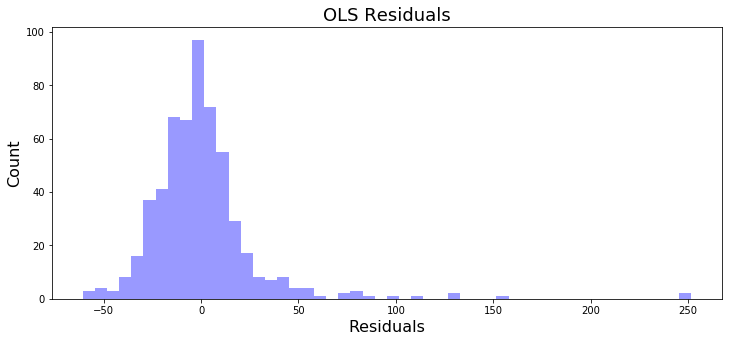

In [68]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Issues over Time')

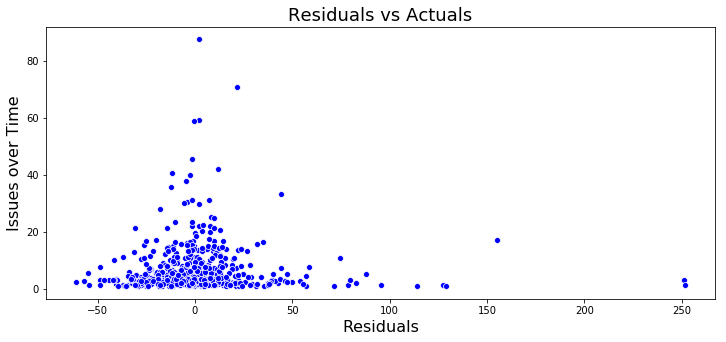

In [69]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
#plt.ylim([0, 20])
#plt.xlim([-0.2, 0.2])

In [70]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-11 22:57:14,708 [8657] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5426667877586255
84
                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_first_comment   No. Observations:                  562
Model:                            GLM   Df Residuals:                      478
Model Family:                   Gamma   Df Model:                           83
Link Function:                    log   Scale:                         0.58016
Method:                          IRLS   Log-Likelihood:                -2219.4
Date:                Sat, 11 Jan 2020   Deviance:                       274.05
Time:                        22:57:15   Pearson chi2:                     277.
No. Iterations:                    49                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
In

In [71]:
glm_marginal_effect('avg_clustering', res, X, all_data)

24.57848417755134

In [72]:
glm_marginal_effect('avg_min_path', res, X, all_data)

40.13855828926761

In [73]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

-180.09498381040697

In [74]:
marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)
effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2


effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-4.658535224980476


2020-01-11 22:57:17,695 [8657] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

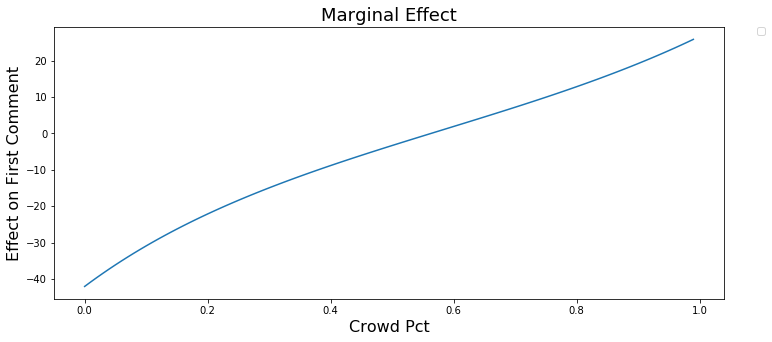

In [75]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


    effects_data['crowd_pct'] = crowd_pct
    effects_data['crowd_pct_2'] = crowd_pct**2


    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

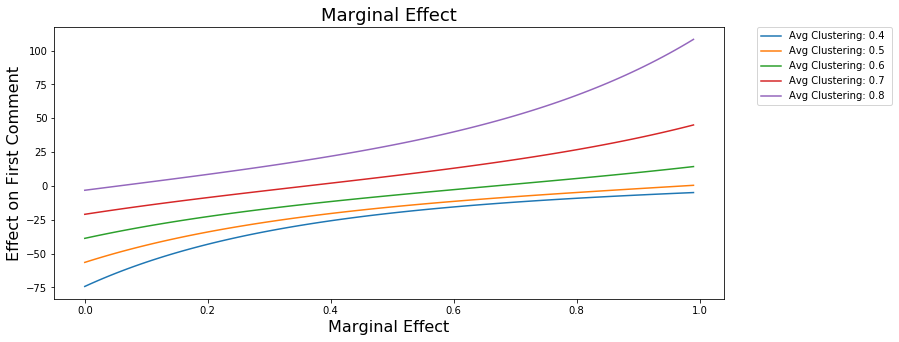

In [76]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Issues Per User

In [77]:
all_data['issues_per_user'].describe()

count    562.000000
mean       5.422194
std        8.544846
min        1.113402
25%        2.192618
50%        3.177866
75%        5.174578
max       97.000000
Name: issues_per_user, dtype: float64

(0, 40)

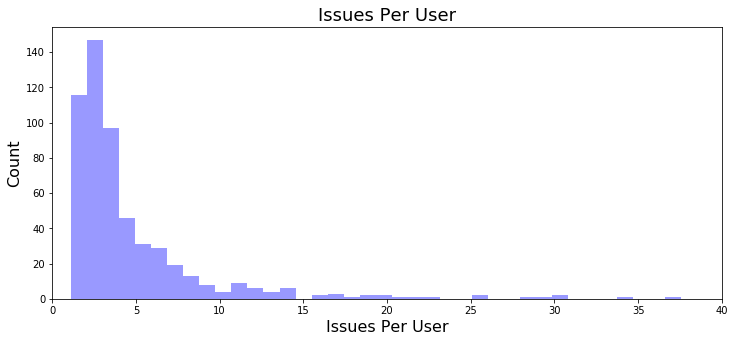

In [78]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_per_user'], kde=False, color='blue', bins=100)
plt.title('Issues Per User', fontsize=18)
plt.xlabel('Issues Per User', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0, 40])

In [79]:
y, X = dmatrices('issues_per_user ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        issues_per_user   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     27.41
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           1.54e-42
Time:                        22:57:27   Log-Likelihood:                -1889.2
No. Observations:                 562   AIC:                             3800.
Df Residuals:                     551   BIC:                             3848.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [80]:
formula = """
issues_per_user ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    gini_coefficientXcrowd_pct + topic_0 + topic_1 + topic_2 + 
    topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + topic_8 + 
    topic_9 + topic_10 + topic_11 + topic_12 + topic_13 + topic_14 + 
    topic_15 + topic_16 + topic_17 + topic_18 + topic_19 + topic_20 + 
    topic_21 + topic_22 + topic_23 + topic_0:topic_2 + topic_0:topic_7 + 
    topic_0:topic_15 + topic_1:topic_4 + topic_1:topic_7 + topic_1:topic_13 + 
    topic_1:topic_14 + topic_1:topic_17 + topic_2:topic_3 + topic_2:topic_8 + 
    topic_2:topic_9 + topic_2:topic_12 + topic_3:topic_4 + topic_3:topic_7 + 
    topic_3:topic_14 + topic_3:topic_18 + topic_4:topic_5 + topic_4:topic_9 + 
    topic_4:topic_11 + topic_4:topic_13 + topic_4:topic_15 + 
    topic_4:topic_17 + topic_4:topic_18 + topic_4:topic_19 + 
    topic_5:topic_9 + topic_5:topic_10 + topic_5:topic_12 + topic_5:topic_17 + 
    topic_6:topic_12 + topic_7:topic_10 + topic_7:topic_17 + 
    topic_7:topic_20 + topic_7:topic_21 + topic_7:topic_23 + 
    topic_8:topic_10 + topic_8:topic_12 + topic_8:topic_17 + 
    topic_8:topic_18 + topic_8:topic_19 + topic_8:topic_20 + 
    topic_9:topic_14 + topic_9:topic_16 + topic_9:topic_18 + 
    topic_10:topic_11 + topic_10:topic_12 + topic_10:topic_15 + 
    topic_10:topic_18 + topic_10:topic_20 + topic_12:topic_20 + 
    topic_13:topic_14 + topic_13:topic_15 + topic_13:topic_17 + 
    topic_13:topic_18 + topic_14:topic_16 + topic_15:topic_17 + 
    topic_15:topic_21 + topic_16:topic_22 + topic_17:topic_20 + 
    topic_17:topic_21 + topic_18:topic_20 + topic_18:topic_23 + 
    topic_7:topic_19 + topic_8:topic_11 + topic_7:topic_22 + 
    topic_1:topic_6 + topic_11:topic_22 + topic_0:topic_22 + 
    topic_2:topic_20
"""

In [81]:
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
X = compute_pca(X, 50)
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

58
                            OLS Regression Results                            
Dep. Variable:        issues_per_user   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     8.288
Date:                Sat, 11 Jan 2020   Prob (F-statistic):           8.68e-44
Time:                        22:57:28   Log-Likelihood:                -1816.8
No. Observations:                 562   AIC:                             3750.
Df Residuals:                     504   BIC:                             4001.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept        

Text(0, 0.5, 'Count')

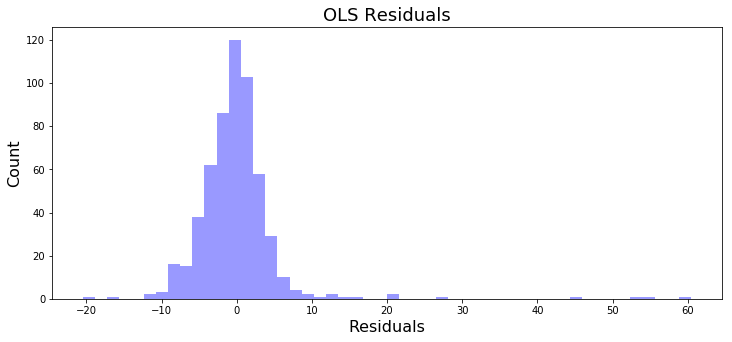

In [82]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

(-10, 10)

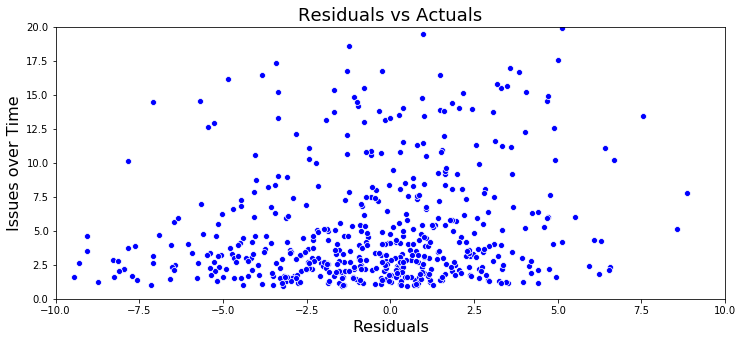

In [83]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 20])
plt.xlim([-10, 10])

In [84]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2020-01-11 22:57:29,373 [8657] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.7451832295205238
58
                 Generalized Linear Model Regression Results                  
Dep. Variable:        issues_per_user   No. Observations:                  562
Model:                            GLM   Df Residuals:                      504
Model Family:                   Gamma   Df Model:                           57
Link Function:                    log   Scale:                         0.37091
Method:                          IRLS   Log-Likelihood:                -1137.3
Date:                Sat, 11 Jan 2020   Deviance:                       110.35
Time:                        22:57:30   Pearson chi2:                     187.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [85]:
glm_marginal_effect('avg_clustering', res, X, all_data)

-1.1223042976941497

In [86]:
glm_marginal_effect('avg_min_path', res, X, all_data)

2.3996832020553884

In [87]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

-6.366972518190555

In [88]:
marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']
gini_coefficient = all_data['gini_coefficient']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)
effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2


effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                   + gini_coefficient * res.params['gini_coefficientXcrowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-16.934601096550722


2020-01-11 22:57:32,667 [8657] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

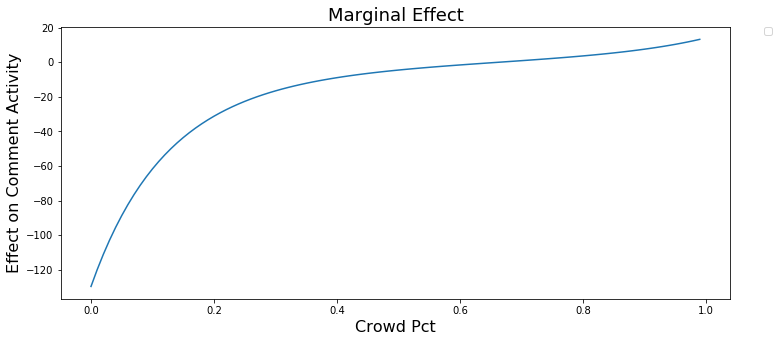

In [89]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct'] = crowd_pct
    effects_data['crowd_pct_2'] = crowd_pct**2


    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + gini_coefficient * res.params['gini_coefficientXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

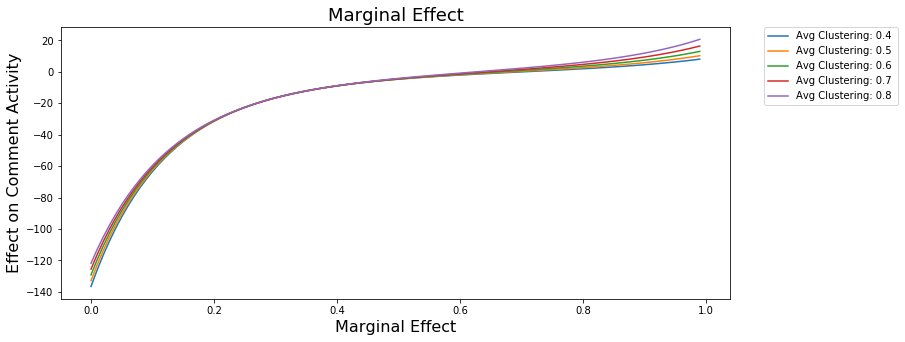

In [90]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

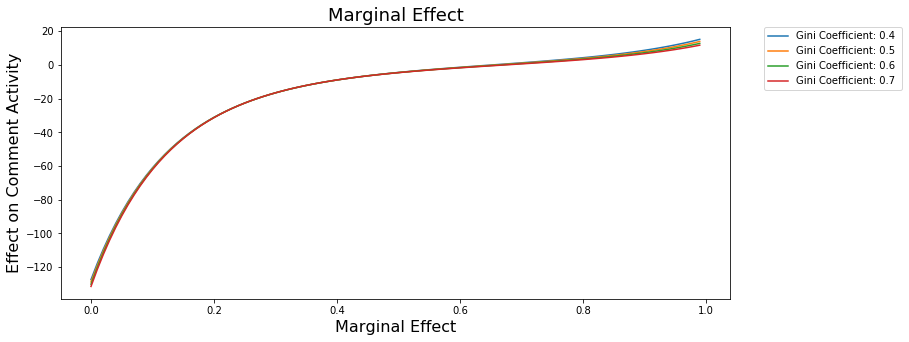

In [91]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)